In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import  Input,Conv2D, MaxPooling2D
from keras.layers import Activation, Dense,Rescaling, MultiHeadAttention,BatchNormalization, Reshape
from tensorflow.keras import activations
from keras.regularizers import l2
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten,Input, BatchNormalization, GlobalMaxPool1D,LSTM
from keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
import tensorflow_addons as tfa
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import os
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from sklearn import preprocessing
import scipy.spatial as sp
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from scipy.stats import skew, kurtosis, iqr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score, mean_squared_error
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler


All Input Variables (Classes): 
['air' 'art' 'government' 'health']
---------------------
size of master_dataset_x:  12
dimensions of features in master_dataset_x:  (675, 7)
minimum length of sequence:  192
maximum length of sequence:  675
size of data_X:  12
Unique Labels:  ['air' 'art' 'government' 'health']
data_X shape:  (12, 675, 7)
data_Y shape:  (12,)
one_hot_encoded shape:  (12, 4)
 air  ----------------------------->  [1. 0. 0. 0.]
 art  ----------------------------->  [0. 1. 0. 0.]
 government  ----------------------------->  [0. 0. 1. 0.]
 health  ----------------------------->  [0. 0. 0. 1.]
X_train shape:  (8, 675, 7)
X_val shape:  (2, 675, 7)
X_test shape:  (2, 675, 7)
y_train shape:  (8, 4)
y_val shape:  (2, 4)
y_test shape:  (2, 4)


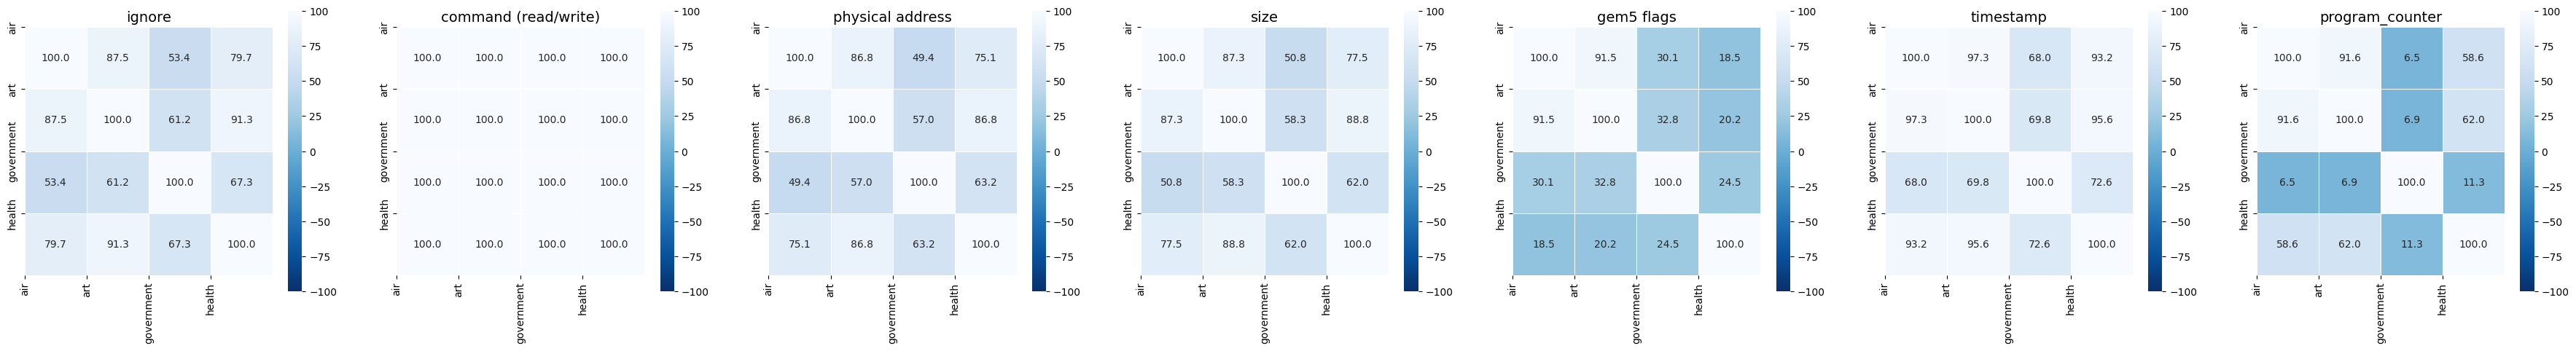

In [2]:
#get list of all file names in directory "data"
file_names = os.listdir(r"D:/Research_work/Trace_Analysis/data5")

#get the part of names in file_names before '-'
input_variables = [name.split('-')[0] for name in file_names]

column_names =['ignore', 'command (read/write)', 'physical address', 'size','gem5 flags', 'timestamp','program_counter']
#find unique elements in input_variables
unique_input_variables = np.unique(input_variables)
print("All Input Variables (Classes): ")
print(unique_input_variables)
print("---------------------")


master_dataset_x=[]
master_dataset_y=[]

for names in file_names:
    #check if names contain string 'icachetrace'
    if 'dcachetrace' in names:
        input_variable=names.split('-')[0] 
        df = pd.read_csv("D:/Research_work/Trace_Analysis/data5/"+ names, sep=',', header=None)
        df.columns = column_names

        #find unique elements in column 'command (read/write)'
        unique_commands=df['command (read/write)'].unique()

        #create dictionary of unique_commands that integer encode the column 'command (read/write)'
        dict_commands = {unique_commands[i]:i for i in range(len(unique_commands))}

        #integer encode 'comand (read/write)' column
        df['command (read/write)'] = df['command (read/write)'].map(dict_commands)

        # convert df to np arrays
        df = df.to_numpy()
        possible_length=len(df)
        master_dataset_x.append(df)
        master_dataset_y.append(input_variable)



print('size of master_dataset_x: ',len(master_dataset_x))
print('dimensions of features in master_dataset_x: ',master_dataset_x[0].shape)


#getting inhomogenous lengths
len_seq=[]
for i in range(len(master_dataset_x)):
    len_seq.append(master_dataset_x[i].shape[0])

min_len_seq=min(len_seq)
print('minimum length of sequence: ',min_len_seq)
max_len_seq=max(len_seq)
print('maximum length of sequence: ',max_len_seq)

#padding zeros
threshold=max_len_seq
for i in range(len(master_dataset_x)):
    #pad zeros if len of sequence is less than threshold
    if master_dataset_x[i].shape[0]<threshold:
        master_dataset_x[i]=np.pad(master_dataset_x[i],((0,threshold-master_dataset_x[i].shape[0]),(0,0)),'constant')




data_X_list=master_dataset_x
data_Y_list=master_dataset_y


#convert to np array
data_X=np.array(data_X_list)
data_Y=np.array(data_Y_list)


#shuffle data
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

data_X, data_Y = unison_shuffled_copies(data_X, data_Y)
print('size of data_X: ',len(data_X))



#partition data for now
part=len(data_X)
data_X=data_X[:part]
data_Y=data_Y[:part]



#non-overlapping windows partitioning (creating more data)
# window=256
# def nearest_multiple(a,window):
#     return int(a/window)*window

# nearest=nearest_multiple(data_X.shape[1],window)
# data_X=data_X[:,:nearest]
# Master_data_X=[]
# Master_data_Y=[]

# for i in range(len(data_X)):
#     for j in range(int(data_X.shape[1]/window)):
#         part_X=data_X[i][j*window:(j+1)*window,:]
#         part_Y=data_Y[i]
#         Master_data_X.append(part_X)
#         Master_data_Y.append(part_Y)


# data_X=np.array(Master_data_X)
# data_Y=np.array(Master_data_Y)




#shuffle
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

data_X, data_Y = unison_shuffled_copies(data_X, data_Y)


#------------------------------------------------------------------------------------------

# # correcting labels
# for i in range(len(data_Y)):
#     subject=data_Y[i]
#     #check if subject has 10 characters
#     if len(subject)<=4:
#         data_Y[i]='class1'
#     if len(subject)<=8 and len(subject)>4:
#         data_Y[i]='class2'
#     if len(subject)<=10 and len(subject)>8:
#         data_Y[i]='class3'




#slicing some variables
vars_2_keep=[i for i in range(7)]
data_X=data_X[:,:,vars_2_keep]
num_vars=len(vars_2_keep)
sliced_features=[column_names[i] for i in vars_2_keep]


#partition data for now--again
part=len(data_X)
data_X=data_X[:part]
data_Y=data_Y[:part]




print("Unique Labels: ",np.unique(data_Y))


print("data_X shape: ", data_X.shape)
print("data_Y shape: ", data_Y.shape)






#one hot encode data_Y
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data_Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
num_classes=int(np.max(integer_encoded)+1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded).astype(float)

print("one_hot_encoded shape: ", onehot_encoded.shape)
mapping = dict(zip(label_encoder.classes_, onehot_encoder.transform(label_encoder.transform(label_encoder.classes_).reshape(num_classes, 1))))
for key,value in mapping.items():
    print("",key," -----------------------------> ",value)


# #####-------smoothing-----##########
for i in range(len(data_X)):
    for j in range(data_X.shape[2]):
        sig=data_X[i,:,j]
        check_sig=sig.copy()
        smooth_sig=gaussian_filter(sig, sigma=2)
        data_X[i,:,j]=smooth_sig

# ################################



#--------------------------------------------------------------------------------------------------------------
#correlation among classes
in_var=np.unique(data_Y)
# sliced_features=[]
# for i in range(data_X.shape[2]):
#     sliced_features.append("f-"+str(i))

plt.figure(figsize=(45,5))
for k in range(data_X.shape[2]):
    ind=k #what index of the feature list to consider
    zero_mat=np.zeros((len(in_var), len(in_var)))
    for i in range(len(in_var)):
        for j in range(len(in_var)):

            #find index of data_Y where it equals unique_input_variables[i] and unique_input_variables[j]
            ind_i=list(np.where(data_Y==in_var[i])[0])
            ind_j=list(np.where(data_Y==in_var[j])[0])

            A=data_X[ind_i,:,ind]
            B=data_X[ind_j,:,ind]
   
            #compare A and B and check if they are equal at any axis=1
            check=[]
            for alpha in range(A.shape[0]):
                sub_check=[]
                for beta in range(B.shape[0]):
                    sub_check.append(1 - sp.distance.cosine(A[alpha,:], B[beta,:]))

                detect=np.mean(np.abs(sub_check))
                check.append(detect)

   
            match_prob=np.mean(check)*100
            zero_mat[i,j]=match_prob

    #plot zero_mat using sklearn heat map and set the limit of the color bar to 100
    plt.subplot(1,data_X.shape[2],k+1)
    sns.heatmap(zero_mat, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r', vmin=-100, vmax=100);
    plt.xticks(range(len(in_var)), in_var, rotation='vertical')
    plt.yticks(range(len(in_var)), in_var)
    #set font size of title
    plt.title(str(sliced_features[ind]), fontsize=14)
#--------------------------------------------------------------------------------------------------------------



#PCA thingy from my COVID paper

data_X_copy=data_X.copy()
# -----------------sklearn minmax scaler
for i in range(data_X.shape[2]):
    scaler = StandardScaler()
    stranded_data=data_X_copy[:,:,i]
    standardized_stranded_data = scaler.fit_transform(stranded_data)
    data_X[:,:,i]=standardized_stranded_data




#----------------------sine transformation
amp1=1.0
amp2=0.5
for i in range(len(data_X)):
    for j in range(data_X.shape[2]):
        if np.max(data_X[i,:,j])!=0:
            data_X[i,:,j]=data_X[i,:,j]+amp1*np.sin(2*np.pi*data_X[i,:,j]/np.max(data_X[i,:,j]))+amp2*np.random.uniform(low=0.5, high=1.3, size=(data_X.shape[1],))
        else:
            data_X[i,:,j]=data_X[i,:,j]+amp1*np.sin(2*np.pi*data_X[i,:,j])+amp2*np.random.uniform(low=0.5, high=1.3, size=(data_X.shape[1],))


#split data into train, validation, and test sets in percentage 70,20,10
X_train, X_test, y_train, y_test = train_test_split(data_X, onehot_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)


num_classes=y_train.shape[1]
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50
NUM_CLASSES = num_classes





In [3]:

acc_list=[]
omega1_list=[]
omega2_list=[]


for omega1 in range(1,3):
    for omega2 in range(omega1+1,omega1+7):
        #get list of all file names in directory "data"
        file_names = os.listdir(r"D:/Research_work/Trace_Analysis/data5")

        #get the part of names in file_names before '-'
        input_variables = [name.split('-')[0] for name in file_names]

        column_names =['ignore', 'command (read/write)', 'physical address', 'size','gem5 flags', 'timestamp','program_counter']
        #find unique elements in input_variables
        unique_input_variables = np.unique(input_variables)



        master_dataset_x=[]
        master_dataset_y=[]

        for names in file_names:
            #check if names contain string 'icachetrace'
            if 'dcachetrace' in names:
                input_variable=names.split('-')[0] 
                df = pd.read_csv("D:/Research_work/Trace_Analysis/data5/"+ names, sep=',', header=None)
                df.columns = column_names

                #find unique elements in column 'command (read/write)'
                unique_commands=df['command (read/write)'].unique()

                #create dictionary of unique_commands that integer encode the column 'command (read/write)'
                dict_commands = {unique_commands[i]:i for i in range(len(unique_commands))}

                #integer encode 'comand (read/write)' column
                df['command (read/write)'] = df['command (read/write)'].map(dict_commands)

                # convert df to np arrays
                df = df.to_numpy()
                possible_length=len(df)
                master_dataset_x.append(df)
                master_dataset_y.append(input_variable)





        #getting inhomogenous lengths
        len_seq=[]
        for i in range(len(master_dataset_x)):
            len_seq.append(master_dataset_x[i].shape[0])

        min_len_seq=min(len_seq)
        max_len_seq=max(len_seq)

        #padding zeros
        threshold=max_len_seq
        for i in range(len(master_dataset_x)):
            #pad zeros if len of sequence is less than threshold
            if master_dataset_x[i].shape[0]<threshold:
                master_dataset_x[i]=np.pad(master_dataset_x[i],((0,threshold-master_dataset_x[i].shape[0]),(0,0)),'constant')




        data_X_list=master_dataset_x
        data_Y_list=master_dataset_y


        #convert to np array
        data_X=np.array(data_X_list)
        data_Y=np.array(data_Y_list)


        #shuffle data
        def unison_shuffled_copies(a, b):
            assert len(a) == len(b)
            p = np.random.permutation(len(a))
            return a[p], b[p]

        data_X, data_Y = unison_shuffled_copies(data_X, data_Y)



        #partition data for now
        part=len(data_X)
        data_X=data_X[:part]
        data_Y=data_Y[:part]



        #non-overlapping windows partitioning (creating more data)
        window=256
        def nearest_multiple(a,window):
            return int(a/window)*window

        nearest=nearest_multiple(data_X.shape[1],window)
        data_X=data_X[:,:nearest]
        Master_data_X=[]
        Master_data_Y=[]

        for i in range(len(data_X)):
            for j in range(int(data_X.shape[1]/window)):
                part_X=data_X[i][j*window:(j+1)*window,:]
                part_Y=data_Y[i]
                Master_data_X.append(part_X)
                Master_data_Y.append(part_Y)


        data_X=np.array(Master_data_X)
        data_Y=np.array(Master_data_Y)


        #partition data for now--again
        part=len(data_X)
        data_X=data_X[:part]
        data_Y=data_Y[:part]


        #shuffle
        def unison_shuffled_copies(a, b):
            assert len(a) == len(b)
            p = np.random.permutation(len(a))
            return a[p], b[p]

        data_X, data_Y = unison_shuffled_copies(data_X, data_Y)

        #------------------------------------------------------------------------------------------

        # correcting labels
        for i in range(len(data_Y)):
            subject=data_Y[i]
            #check if subject has 10 characters
            if len(subject)<=3+omega1:
                data_Y[i]='class1'
            if len(subject)<=3+omega2 and len(subject)>3+omega1:
                data_Y[i]='class2'
            if len(subject)<=10 and len(subject)>3+omega2:
                data_Y[i]='class3'



        #slicing some variables
        vars_2_keep=[i for i in range(7)]
        data_X=data_X[:,:,vars_2_keep]
        num_vars=len(vars_2_keep)
        sliced_features=[column_names[i] for i in vars_2_keep]


        #partition data for now--again
        part=256
        data_X=data_X[:part]
        data_Y=data_Y[:part]




        #one hot encode data_Y
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(data_Y)
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        num_classes=int(np.max(integer_encoded)+1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded).astype(float)


        mapping = dict(zip(label_encoder.classes_, onehot_encoder.transform(label_encoder.transform(label_encoder.classes_).reshape(num_classes, 1))))


        #PCA thingy from my COVID paper

        data_X_copy=data_X.copy()
        # -----------------sklearn minmax scaler
        for i in range(data_X.shape[2]):
            scaler = StandardScaler()
            stranded_data=data_X_copy[:,:,i]
            standardized_stranded_data = scaler.fit_transform(stranded_data)
            data_X[:,:,i]=standardized_stranded_data




        #----------------------sine transformation
        amp1=1.0
        amp2=0.5
        for i in range(len(data_X)):
            for j in range(data_X.shape[2]):
                if np.max(data_X[i,:,j])!=0:
                    data_X[i,:,j]=data_X[i,:,j]+amp1*np.sin(2*np.pi*data_X[i,:,j]/np.max(data_X[i,:,j]))+amp2*np.random.uniform(low=0.5, high=1.3, size=(data_X.shape[1],))
                else:
                    data_X[i,:,j]=data_X[i,:,j]+amp1*np.sin(2*np.pi*data_X[i,:,j])+amp2*np.random.uniform(low=0.5, high=1.3, size=(data_X.shape[1],))


        #split data into train, validation, and test sets in percentage 70,20,10
        X_train, X_test, y_train, y_test = train_test_split(data_X, onehot_encoded, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

        BATCH_SIZE = 32
        LEARNING_RATE = 1e-3
        WEIGHT_DECAY = 1e-4
        EPOCHS = 100
        NUM_CLASSES = num_classes


        #------------------------Time2Vec------------------------#
        #https://www.kaggle.com/code/danofer/time2vec-water-levels

        class T2V(Layer):
            
            def __init__(self, output_dim=None, **kwargs):
                self.output_dim = output_dim
                super(T2V, self).__init__(**kwargs)
                
            def build(self, input_shape):

                self.W = self.add_weight(name='W',
                                        shape=(input_shape[-1], self.output_dim),
                                        initializer='uniform',
                                        trainable=True)

                self.P = self.add_weight(name='P',
                                        shape=(input_shape[1], self.output_dim),
                                        initializer='uniform',
                                        trainable=True)

                self.w = self.add_weight(name='w',
                                        shape=(input_shape[1], 1),
                                        initializer='uniform',
                                        trainable=True)

                self.p = self.add_weight(name='p',
                                        shape=(input_shape[1], 1),
                                        initializer='uniform',
                                        trainable=True)

                super(T2V, self).build(input_shape)
                
            def call(self, x):
                
                original = self.w * x + self.p
                sin_trans = K.sin(K.dot(x, self.W) + self.P)
                
                return K.concatenate([sin_trans, original], -1)




        def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
            # Normalization and Attention
            x = layers.LayerNormalization(epsilon=1e-6)(inputs)
            x = layers.MultiHeadAttention(
                key_dim=head_size, num_heads=num_heads, dropout=dropout
            )(x, x)
            x = layers.Dropout(dropout)(x)
            res = x + inputs

            # Feed Forward Part
            x = layers.LayerNormalization(epsilon=1e-6)(res)
            x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
            x = layers.Dropout(dropout)(x)
            x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
            return x + res


        t2v_dim=64
        head_size=256
        num_heads=16
        ff_dim=4
        num_transformer_blocks=2
        mlp_units=[64]
        mlp_dropout=0.6
        dropout=0.25

        n_timesteps = X_train.shape[1]
        n_features = X_train.shape[2]
        input_shape = (n_timesteps, n_features)
        inputs = keras.Input(shape=input_shape)
        x = T2V(t2v_dim)(inputs)
        for _ in range(num_transformer_blocks):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
        for dim in mlp_units:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(mlp_dropout)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        model=Model(inputs, outputs)



        #compile model
        class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
            def __init__(
                self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
            ):
                super(WarmUpCosine, self).__init__()
                self.learning_rate_base = learning_rate_base
                self.total_steps = total_steps
                self.warmup_learning_rate = warmup_learning_rate
                self.warmup_steps = warmup_steps
                self.pi = tf.constant(np.pi)

            def __call__(self, step):
                if self.total_steps < self.warmup_steps:
                    raise ValueError("Total_steps must be larger or equal to warmup_steps.")
                cos_annealed_lr = tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
                learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
                if self.warmup_steps > 0:
                    if self.learning_rate_base < self.warmup_learning_rate:
                        raise ValueError(
                            "Learning_rate_base must be larger or equal to "
                            "warmup_learning_rate."
                        )
                    slope = (
                        self.learning_rate_base - self.warmup_learning_rate
                    ) / self.warmup_steps
                    warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
                    learning_rate = tf.where(
                        step < self.warmup_steps, warmup_rate, learning_rate
                    )
                return tf.where(
                    step > self.total_steps, 0.0, learning_rate, name="learning_rate"
                )


        total_steps = int((len(y_train) / BATCH_SIZE) * EPOCHS)
        warmup_epoch_percentage = 0.15
        warmup_steps = int(total_steps * warmup_epoch_percentage)
        scheduled_lrs = WarmUpCosine(
            learning_rate_base=LEARNING_RATE,
            total_steps=total_steps,
            warmup_learning_rate=0.0,
            warmup_steps=warmup_steps,
        )

        optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        #callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

        #train model
        history = model.fit(X_train, y_train, epochs=EPOCHS,batch_size=4, validation_data=(X_val, y_val),verbose=0, callbacks=[early_stopping])


        b,a=model.evaluate(X_test, y_test,verbose=0)
        acc_list.append(a)
        omega1_list.append(omega1)
        omega2_list.append(omega2)


#find index of max of acc_list
max_acc_index = acc_list.index(max(acc_list))

omega1 = omega1_list[max_acc_index]
omega2 = omega2_list[max_acc_index]

print("Found the partitions to be best: 3 to "+str(3+omega1)+", "+str(3+omega1)+" to "+str(3+omega2)+" and "+str(3+omega2)+" to 10 with accuracy: "+str(acc_list[max_acc_index]))


Restoring model weights from the end of the best epoch: 5.
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 27: earl

Text(0, 0.5, 'Accuracy of Dummy Model')

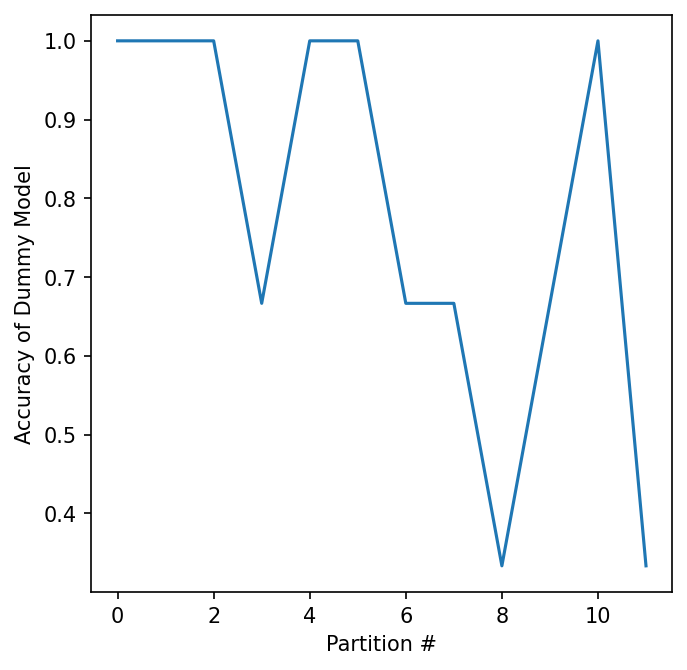

In [4]:
#plot accuracy
plt.figure(figsize=(5, 5),dpi=150)
plt.plot(acc_list)
plt.xlabel('Partition #')
plt.ylabel('Accuracy of Dummy Model')
